## Flow Matching

[Flow Matching](https://arxiv.org/abs/2210.02747) is a modification of diffusion models, so if you are unfamilar with diffusion check out the [diffusion notebook](https://github.com/harveymannering/GenerativeModelsFromScratch/blob/main/denoising_diffusion_probabilistic_models.ipynb) in [this repo](https://github.com/harveymannering/GenerativeModelsFromScratch).  Like diffusion, flow matching maps one distibution to another. 

In [1]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from diffusers import UNet2DModel
from tqdm import tqdm
from torchdyn.core import NeuralODE
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

c:\Users\hgm1g14\AppData\Local\anaconda3\envs\torchenv\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## Model

The neural network architectures we will use is a UNet with three downsampling blocks and three upsampling blocks.  We will creates this network using the diffusers library and you can change its archicture via the `config` variable.  For example, you change the depth of the network using the `layers_per_block` option, which controls the number of layer for each of the up/down blocks.

This exact architecture is also commonly used for diffusion models.

In [3]:
# Define network structure and parameters
config = {
    '_class_name': 'UNet2DModel',
    '_diffusers_version': '0.0.4',
    'act_fn': 'silu',
    'attention_head_dim': None,
    'block_out_channels': [32, 64, 64],
    'center_input_sample': False,
    'down_block_types': ['DownBlock2D', 'AttnDownBlock2D', 'DownBlock2D'],
    'downsample_padding': 0,
    'flip_sin_to_cos': False,
    'freq_shift': 1,
    'in_channels': 1,
    'layers_per_block': 8,
    'mid_block_scale_factor': 1,
    'norm_eps': 1e-06,
    'norm_num_groups': 32,
    'out_channels': 1,
    'sample_size': 32,
    'time_embedding_type': 'positional',
    'up_block_types': ['UpBlock2D', 'AttnUpBlock2D', 'UpBlock2D']
}

# Create the neural network
model = UNet2DModel.from_config(config)

## Data

In this example we will use the MNIST dataset, which contains 60000 training images and 10000 testing images of handwritten digits. Let's download and plot some examples from the training data.

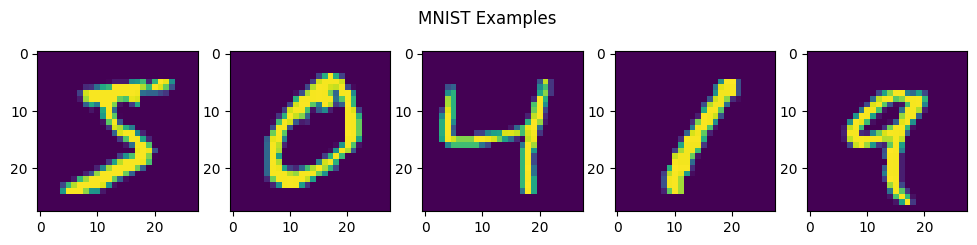

In [4]:
# Transforms to be applied to all images in the dataset
tf = transforms.Compose(
    [transforms.ToTensor()]
)

# Download/setup the MNIST dataset
dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=tf,
)

# Plot examples
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('MNIST Examples')
ax[0].imshow(dataset[0][0][0,:,:].numpy())
ax[1].imshow(dataset[1][0][0,:,:].numpy())
ax[2].imshow(dataset[2][0][0,:,:].numpy())
ax[3].imshow(dataset[3][0][0,:,:].numpy())
ax[4].imshow(dataset[4][0][0,:,:].numpy())


## Training

Our object is to map from a simple Gaussian distribution to a more complexe distribution, which in this case in the distribution of MNIST images.  To do this will follow a continuous path $p_t$ where $t$ represents time. The start and end of the path are denoted with $p_0$ and $p_1$ respectivly.  From $p_t$ we then generate a corresponding vector field $u_t$ which will then try to learn using a neural network $v_t$

$$\mathcal{L}_{\text{FM}}(\theta) = \mathbb{E}_{t, p_t(x)} \| v_t(x) - u_t(x) \|^2 $$

where $x$ is an image that has corrupted with noise and $\theta$ are the parameters of out neural network.

We cannot optimize this objective however, because computing $u_t$ is intractable.  Suprisingly, simply by conditioning $u_t$ on $x_1$ mean not only that we can now optimize the objective, but we will reach that same optima as the original objective.

$$\mathcal{L}_{\text{CFM}}(\theta) = \mathbb{E}_{t, q(x_1),p_t(x|x_1)} \| v_t(x) - u_t(x|x_1) \|^2 $$

where $q$ is our target distribution. For $t$ we uniformly sample between $0$ and $1$.

The simplest method of computing the vector field is simply using the following equation

$$ u_t(x|x_1) = x_1 - x_0$$

In [5]:
def compute_conditional_vector_field(x0, x1):
    return x1 - x0

Recall that $p_t$ describes our path from $x_0$ to $x_1$.  To be more precise, $p_t$ is a time dependent probability density function which can be modelled simply with a Gaussian distribution where $\mu$ is a linear interpolation between $x_0$ and $x_1$, and $\sigma$ is a small constant greater than $0$.

$$ p_t(x|x_1) = \mathcal{N}(x | tx_1 + (1 − t)x_0, \sigma^2) $$

In [6]:
def sample_conditional_pt(x0, x1, t, sigma):
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

Now let's train out models.  Training will use the $\mathcal{L}_{\text{CFM}}$ loss function and use the following optimization process:


1. $~~\text{repeat}$
2. $~~~~~~x_1 \sim q(x_1)$
3. $~~~~~~t \sim \text{Uniform}(0,1)$
4. $~~~~~~x \sim p_t(x|x_1)$
5. $~~~~~~\text{taking gradient descent step on}$
6. $~~~~~~~~~~~∇_{θ}\| v_t(x) - u_t(x|x_1) \|^2$
7. $~~~~~~\text{until convergence}$

Feel free to tune the hyper parameters.  If training is too long, try decreasing the `num_epochs` and in some scenarios decreasing the `batch_size` will help too.  However, both changes will lead to worse perfomance.  Training took me around 20 minutes on an NVIDIA GeForce 4060.


In [7]:
# Are we using the CPU or the GPU?
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Define loss function
mse_loss = nn.MSELoss()

# Define hyperparameters
num_epochs = 10
batch_size = 150

# Define optimiser and dataset objects
optimizer = torch.optim.Adam(model.parameters())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss history arrays
loss_history = []

# Training loop
for epoch in range(num_epochs):
    # Reset total loss trackers
    total_loss = 0

    # Iterate over all MNIST dataset items
    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Load a batch of MNIST data in to memory
        x1 = (Variable(data[0]) * 2) - 1
        x1 = x1.to(device)

        # Generate random Gaussian noise
        x0 = torch.randn_like(x1)

        # Generate random timesteps between 0 and 1000
        t = torch.rand(x0.shape[0]).type_as(x0)

        # Corrupt image with noise 
        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)

        # Sample a vector field which will be the target of our training
        ut = compute_conditional_vector_field(x0, x1)

        # - Forward pass -
        # t should be between 0 and 1, however the architecture we are using was design to use t value between 0 and 1000, so we will multiply t by 1000 here only 
        vt = model(xt, t * 1000)['sample']

        # Calculate means square error loss
        loss = torch.mean((vt - ut) ** 2)
        total_loss += loss.item()

        # Backwards Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save and print loss
    loss_history.append(total_loss / len(dataset))
    print('Epoch [{}/{}], Loss:{:.4f}'.format(epoch+1, num_epochs, total_loss / len(dataset)))

torch.save(model, 'checkpoint_flow_matching.pth')

  0%|          | 0/400 [00:00<?, ?it/s]c:\Users\hgm1g14\AppData\Local\anaconda3\envs\torchenv\lib\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 400/400 [01:48<00:00,  3.70it/s]


Epoch [1/10], Loss:0.0018


100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch [2/10], Loss:0.0014


100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch [3/10], Loss:0.0014


100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch [4/10], Loss:0.0013


100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch [5/10], Loss:0.0013


100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch [6/10], Loss:0.0013


100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch [7/10], Loss:0.0013


100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch [8/10], Loss:0.0013


100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch [9/10], Loss:0.0013


100%|██████████| 400/400 [01:51<00:00,  3.58it/s]

Epoch [10/10], Loss:0.0013


Text(0.5, 1.0, 'Flow Matching Training Loss')

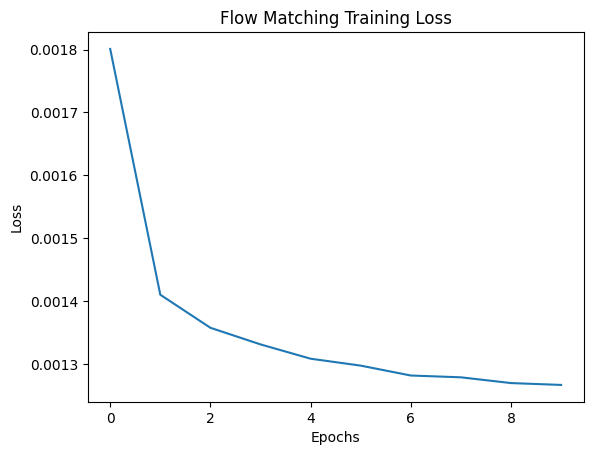

In [8]:
# Plot the training loss as measures using MSE
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Flow Matching Training Loss')

## Sampling

As part of the torchdyn library we will first need to define a wrapper to run inference on our model.

In [9]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(x, t * 1000)['sample']

Now lets generate some images!  This step involve define an ordinary differential equation (ODE) solver, in this case we will be using the [Dormand–Prince method](https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method), but any off-the-shelf ODE will do here.  

The neural network $v_t$ we just trained defines the vector field. Starting from a Gaussian distribution, we will follow the trajectory created by vector fields over 100 step, eventually ending up within the distribution of MNIST images.

In [12]:
# Define our Ordinary Differential Equation (ODE) solver
node = NeuralODE(
    torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)

# Use ODE solver to follow the trejectory created by our neural network
with torch.no_grad():
    traj = node.trajectory(
        torch.randn_like(x1),
        t_span=torch.linspace(0, 1, 100),
    )

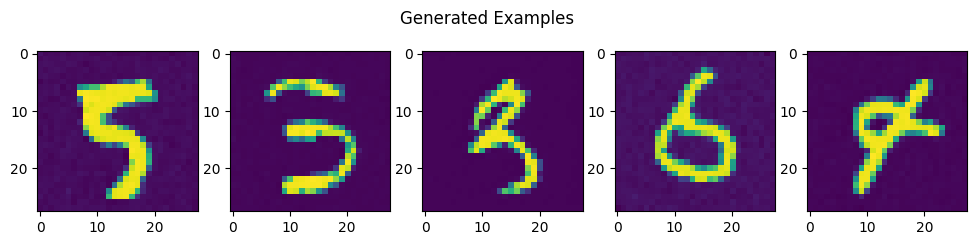

In [13]:
# Show 5 example generated images
total_examples = 5
fig, ax= plt.subplots(1, total_examples, figsize=(12, 2.5))
fig.suptitle('Generated Examples')
for i in range(total_examples):
    ax[i].imshow(traj[-1,i,0].cpu().numpy())